# Import packages

In [94]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
plt.style.use('seaborn')


# Load File

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')

# Data Exploration

In [3]:
df.yr_renovated.value_counts()

0       19171
2014       86
2005       34
2003       34
2013       33
        ...  
1934        1
1951        1
1948        1
1954        1
1956        1
Name: yr_renovated, Length: 70, dtype: int64

In [4]:
df.bedrooms.value_counts()

3     9101
4     6354
2     2567
5     1478
6      251
1      179
7       36
8       12
0       11
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

# Pre-processing

In [5]:
df = (df

    .drop(labels = 'id', axis = 1)

    .assign(date = lambda x: x.date.str.slice(start = 0, stop = 8)

     , year = lambda x: x.date.str.slice(start=0, stop=4)

     , month = lambda x: x.date.str.slice(start=4, stop = 6)

     , day = lambda x: x.date.str.slice(start=6, stop= 8))

    .drop(labels = 'date', axis = 1)

)

In [6]:
df['month'] = df['month'].astype(int)

In [7]:
df['day'] = df['day'].astype(int)

In [8]:
df['year'] = df['year'].astype(int)

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
df = df.assign(lat_normalized = MinMaxScaler().fit_transform(np.array(df.lat).reshape(-1,1)))


In [11]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.90)
IQR = Q3 - Q1


In [12]:
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape

(15901, 23)

In [13]:
import math

def long_to_feet(long):

  return long*288_200

def lat_to_feet(lat):

  return lat*364_000

def distance(ax, ay):

    #Put in the X & Y of two points to get the distance between them.

    w = (long_to_feet(ax) - long_to_feet(-122.25734720828268)) / 5280

    w2 = w * w

    h = (lat_to_feet(47.61693898705242) - lat_to_feet(ay)) / 5280

    h2 = h * h

    # l = math.sqrt(h2 + w2)

    l = (h2 + w2)**0.5

    return l

df = df.assign(

    dist = lambda x: distance(x.long,x.lat)

)

# Model

In [14]:
target = df.price
features = df.drop(columns="price",axis=1)

In [15]:
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=.10,train_size=.90)

In [16]:
est = HistGradientBoostingRegressor(max_bins=255, n_iter_no_change=20, max_depth=250, min_samples_leaf=20, max_leaf_nodes=20, max_iter=159, random_state=200000, learning_rate=0.125).fit(X_train, y_train)

In [17]:
predictions_est = est.predict(X_test)
# y_predicted_holdout = est.predict(new_data_holdout)


In [18]:
est.score(X_train, y_train)

0.9416795633961437

In [19]:
result_est = mean_squared_error(y_test, predictions_est, squared=False)
result_est

67712.94099980441

In [20]:
import pickle

s = pickle.dumps(est)

clf = pickle.loads(s)

In [21]:
with open("Kody_classifier.txt", "wb") as infile:
  infile.write(s) 

In [ ]:
result = permutation_importance(
    est, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(df.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")

plt.show()

In [ ]:
print(result.importances_mean)

In [127]:
d = {'importance': result.importances_mean, 'features': np.array(df.columns)[sorted_idx]}

In [128]:
feat_df = pd.DataFrame(data=d)

In [144]:
(alt.Chart(feat_df).mark_bar()
  .encode(x=alt.X("features",sort="-y",
                  scale=alt.Scale(domain=(["sqft_living","view","lat","year","sqft_above","day","zipcode","sqft_lot15","yr_built","bathrooms","long","condition"]))),
          y=alt.Y("importance",scale=alt.Scale(domain=(0,0.45)))))

alt.Chart(...)

In [50]:
import altair as alt
from tqdm import tqdm

In [58]:
feat_imp_diz = permutation_importance(
    est, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

feat_imp_mean = result.importances_mean
feat_imp_std = result.importances_std

feat_imp_mean = pd.Series(feat_imp_mean)
feat_imp_std = pd.Series(feat_imp_std)

order = feat_imp_mean.sort_values(ascending=False).index
feat_imp_mean = feat_imp_mean[order]
feat_imp_std = feat_imp_std[order]

In [61]:
sorted_idx = result.importances_mean.argsort()

TypeError: ignored

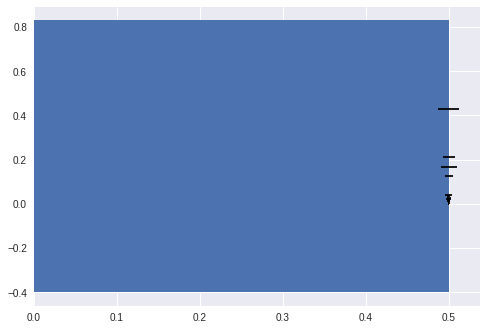

In [103]:
fig, ax = plt.subplots()

hbars = ax.barh(feat_imp_mean, xerr=feat_imp_std, align='center',width=.5)
ax.set_yticks(feat_imp_mean, label=sorted_idx)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('How fast do you want to go today?')

# Label with specially formatted floats
ax.bar_label(hbars, fmt='%.2f')
ax.set_xlim(right=15)  # adjust xlim to fit labels

plt.show()

In [23]:
print(result)

{'importances_mean': array([ 1.58019778e-03,  2.00374167e-03,  2.11529956e-01,  3.28385885e-02,
        7.42527264e-04,  0.00000000e+00,  0.00000000e+00,  1.10124619e-02,
        1.26337880e-01,  2.35979943e-02,  2.78143322e-03,  2.68746415e-02,
        0.00000000e+00,  8.17894696e-03,  4.29868569e-01,  3.90123867e-02,
        1.86037770e-02,  2.31765952e-03,  1.06036444e-02,  2.21275672e-03,
       -4.00743506e-04,  0.00000000e+00,  1.67714809e-01]), 'importances_std': array([0.00036821, 0.00046693, 0.00735942, 0.00214648, 0.00027755,
       0.        , 0.        , 0.00181514, 0.00456278, 0.00305281,
       0.0007977 , 0.00262183, 0.        , 0.00090158, 0.01266333,
       0.00430914, 0.0016132 , 0.00096184, 0.00178507, 0.00075005,
       0.00046492, 0.        , 0.00941184]), 'importances': array([[ 1.25059156e-03,  1.55797011e-03,  2.03700870e-03,
         1.17752637e-03,  1.42413045e-03,  1.50593027e-03,
         1.25297918e-03,  2.42957887e-03,  1.67636547e-03,
         1.48989685e

In [32]:
new_result = {}
for i in range(0,len(result["importances_mean"])): 
        array = result["importances_mean"]
        # for x in array:
        #   avg = array[x].mean()
        #   new_result["average"] += avg
print(array)
print(new_result)

[ 1.32556598e+04  1.68086034e+04  1.77444188e+06  2.75470046e+05
  6.22877015e+03  0.00000000e+00  0.00000000e+00  9.23792258e+04
  1.05979895e+06  1.97954324e+05  2.33323529e+04  2.25440833e+05
  0.00000000e+00  6.86099799e+04  3.60599892e+06  3.27259619e+05
  1.56059792e+05  1.94419372e+04  8.89498159e+04  1.85619487e+04
 -3.36168018e+03  0.00000000e+00  1.40689379e+06]
{}


### Make an average of permutations and put that into a bar chart


# Visualizations


### sqft_living, dist,lat,sqft_living15,long,waterfront